In [1]:
# imports
import torch
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
#import wandb
#from prettytable import PrettyTable
import random
import os
from datetime import datetime
from torch.optim import lr_scheduler
import pandas as pd
from skimage import exposure

# local imports
from models_parameters import losses
from utils import helper_functions
from utils.dataloader import Dataset as dataset
from utils.losses import calculate_metrics
import matplotlib.image as mpimg


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

C:\Users\accou\anaconda3\envs\geo_env3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [2]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def minmax_percentile(img,perc=2):
  lower = np.percentile(img,perc)
  upper = np.percentile(img,100-perc)
  img[img>upper] = upper
  img[img<lower] = lower
  return(img-np.min(img) ) / (np.max(img)-np.min(img))

In [2]:
def load_dataloader(dl_type="normal",sen2_test_tile="T30TWT"):
    working_directory = "C:\\Users\\accou\\Documents\\thesis_final_models\\comparison\\"
    folder_path = "C:\\Users\\accou\\Documents\\thesis\\data\\"
    dataset_file = "C:\\Users\\accou\\Documents\\thesis\\images_subfolders3.pkl"
    
    from utils.dataloader import Dataset as dataset
    dataset_test   = dataset(folder_path,dataset_file,transform=dl_type,sen2_amount=1, sen2_tile = sen2_test_tile,   location="local")
    loader_test = DataLoader(dataset_test,batch_size=1, shuffle=False, num_workers=0,pin_memory=True,drop_last=False)
    
    return loader_test

In [4]:
loader_standardize = load_dataloader(dl_type="standardize")
loader_moment = load_dataloader(dl_type="moment_matching")
loader_matching = load_dataloader(dl_type="histogram_matching")

In [5]:
def create_histograms(loader,title):
    def plot_images(a,title,title_plot):  # plot
        a = a.cpu().detach().numpy()[0]
        a = np.transpose(a,(1,2,0))    
        a = minmax_percentile(a,perc=0)
    
        fig, ax = plt.subplots(figsize=(6,6))
        ax.imshow(a)
        ax.set_title(title+"\n"+title_plot)
        ax.axis('off')
        plt.savefig("image_"+title+"_"+title_plot.replace(" ","_")+".png".replace(" ","_"),dpi=500,bbox_inches='tight')
        #plt.plot()
    
    lr,hr = next(iter(loader))
    
    plot_images(hr,title="SPOT-6",title_plot=title)
    plot_images(lr,title="Sentinel-2",title_plot=title)
    

    img = lr[0].numpy()
    img = rgb2gray(img.transpose(1,2,0))
    img = np.sort(np.ravel(img))
    fig,ax_left = plt.subplots(figsize=(5,5))
    ax_right = ax_left.twinx()
    p = 1. * np.arange(len(img)) / (len(img) - 1)
    ax_left.hist(np.ravel(img),bins=50, histtype='bar', color='blue',label="Histogram")
    ax_left.set_ylabel('Pixel Count')
    ax_left.set_xlabel('Pixel Value')
    ax_right.plot(img, p,color="red",label="CDF")
    ax_right.set_ylabel('Cummulative Distribution Function')
    ax_left.legend(loc="upper left")
    ax_right.legend(loc="upper right")
    plt.title("Sentinel-2 - "+str(title))
    plt.savefig("sentinel_graph_"+title.replace(" ","_")+".png",dpi=500,bbox_inches='tight')
    plt.plot()
    
    img = hr[0].numpy()
    img = rgb2gray(img.transpose(1,2,0))
    img = np.sort(np.ravel(img))
    fig,ax_left = plt.subplots(figsize=(5,5))
    ax_right = ax_left.twinx()
    p = 1. * np.arange(len(img)) / (len(img) - 1)
    ax_left.hist(np.ravel(img),bins=50, histtype='bar', color='blue',label="Histogram")
    ax_left.set_ylabel('Pixel Count')
    ax_left.set_xlabel('Pixel Value')
    ax_right.plot(img, p,color="red",label="CDF")
    ax_right.set_ylabel('Cummulative Distribution Function')
    ax_left.legend(loc="upper left")
    ax_right.legend(loc="upper right")
    plt.title("SPOT-6 - "+str(title))
    plt.savefig("spot_graph_"+title.replace(" ","_")+".png",dpi=500,bbox_inches='tight')
    plt.plot()
    

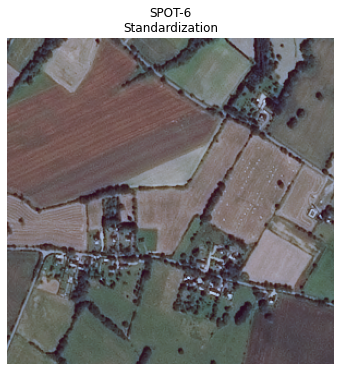

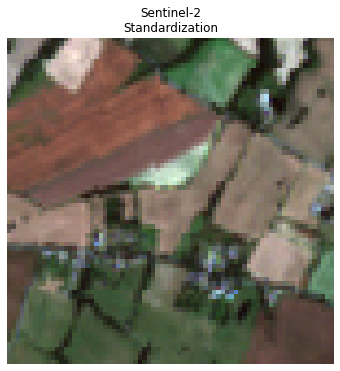

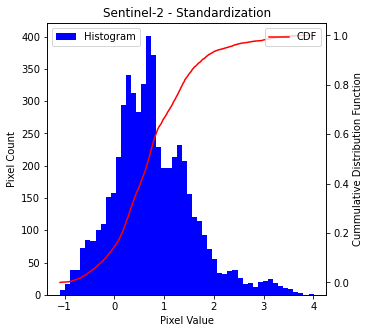

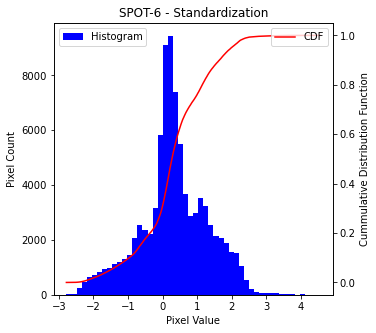

In [6]:
create_histograms(loader_standardize,title="Standardization")

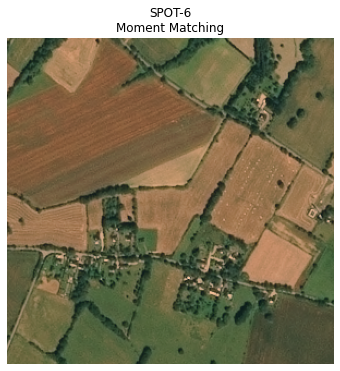

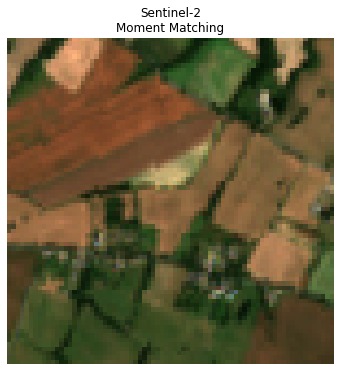

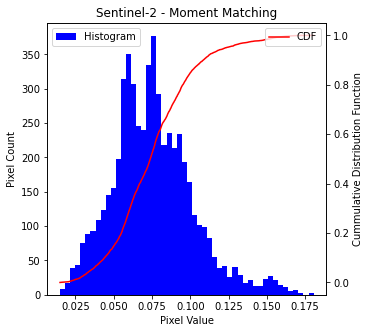

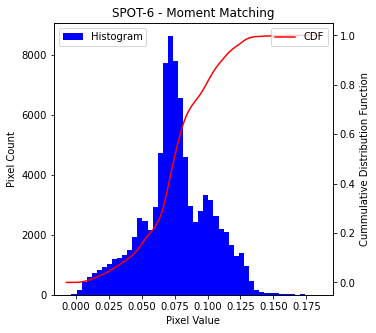

In [7]:
create_histograms(loader_moment,title="Moment Matching")

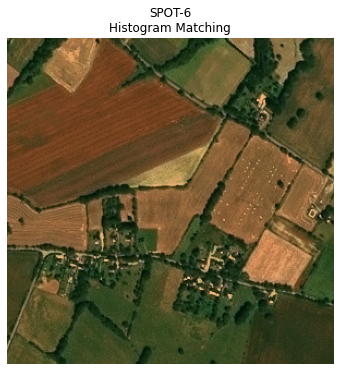

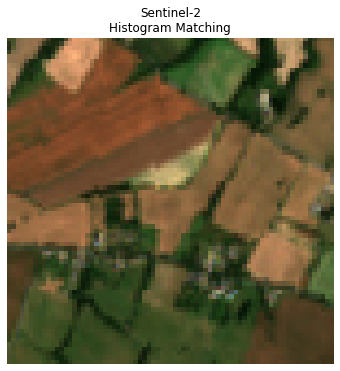

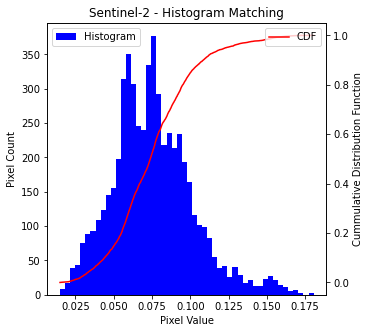

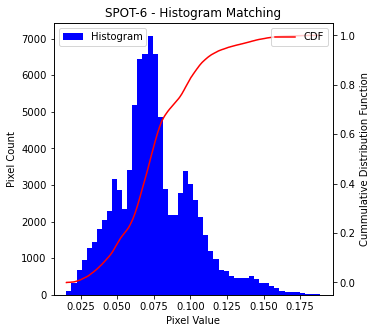

In [8]:
create_histograms(loader_matching,title="Histogram Matching")

# Display Images in order

In [9]:
def combine(a,b,c,d,title):
    a = mpimg.imread(a)
    b = mpimg.imread(b)
    c = mpimg.imread(c)
    d = mpimg.imread(d)
    
    fig, axs = plt.subplots(2, 2,figsize=(15,15))
    axs[0,0].imshow(a)
    axs[0,1].imshow(b)
    axs[1,0].imshow(c)
    axs[1,1].imshow(d)
    axs[0,0].axis('off')
    axs[0,1].axis('off')
    axs[1,0].axis('off')
    axs[1,1].axis('off')

    plt.tight_layout(rect=[0,0,1,1])
    plt.savefig(title,dpi=500,bbox_inches='tight')
    plt.show()

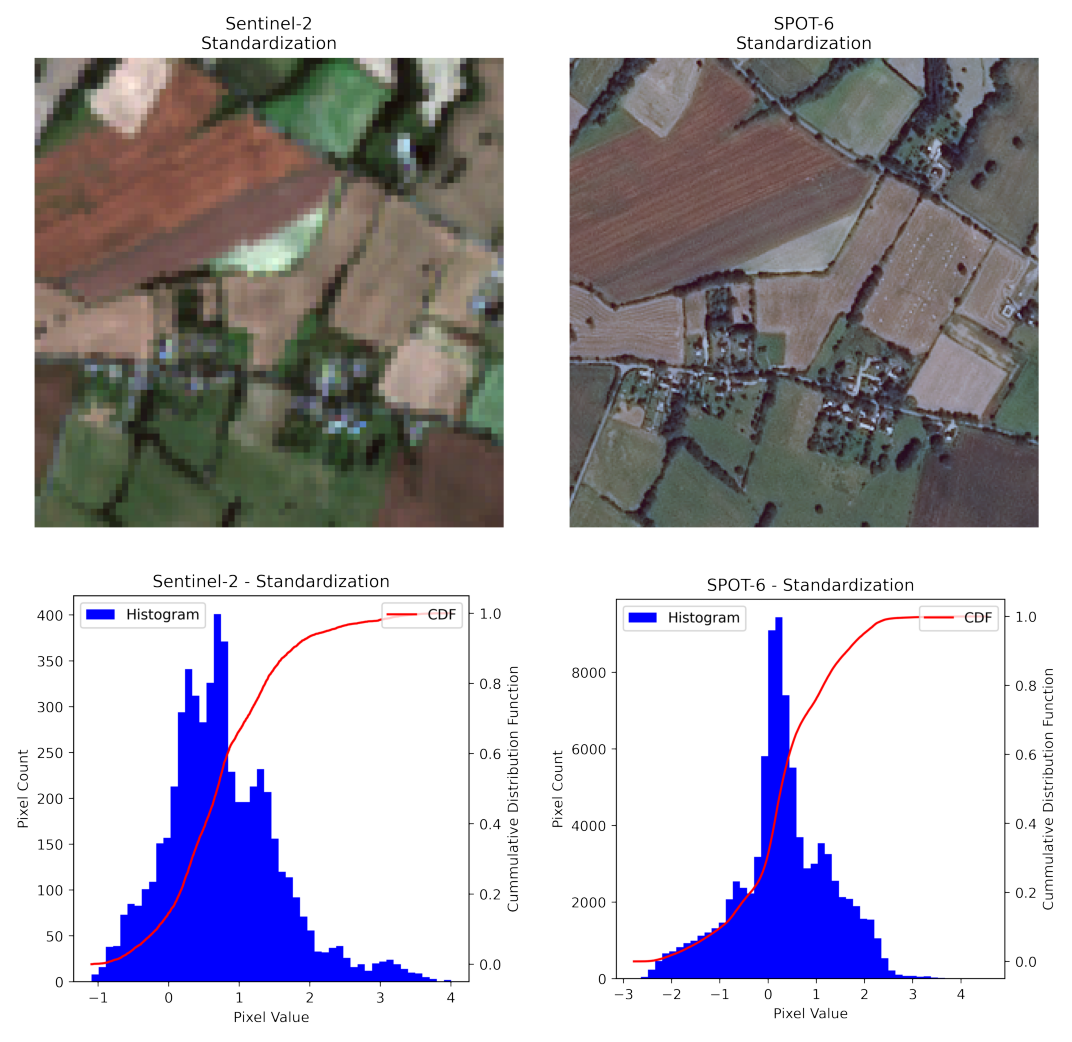

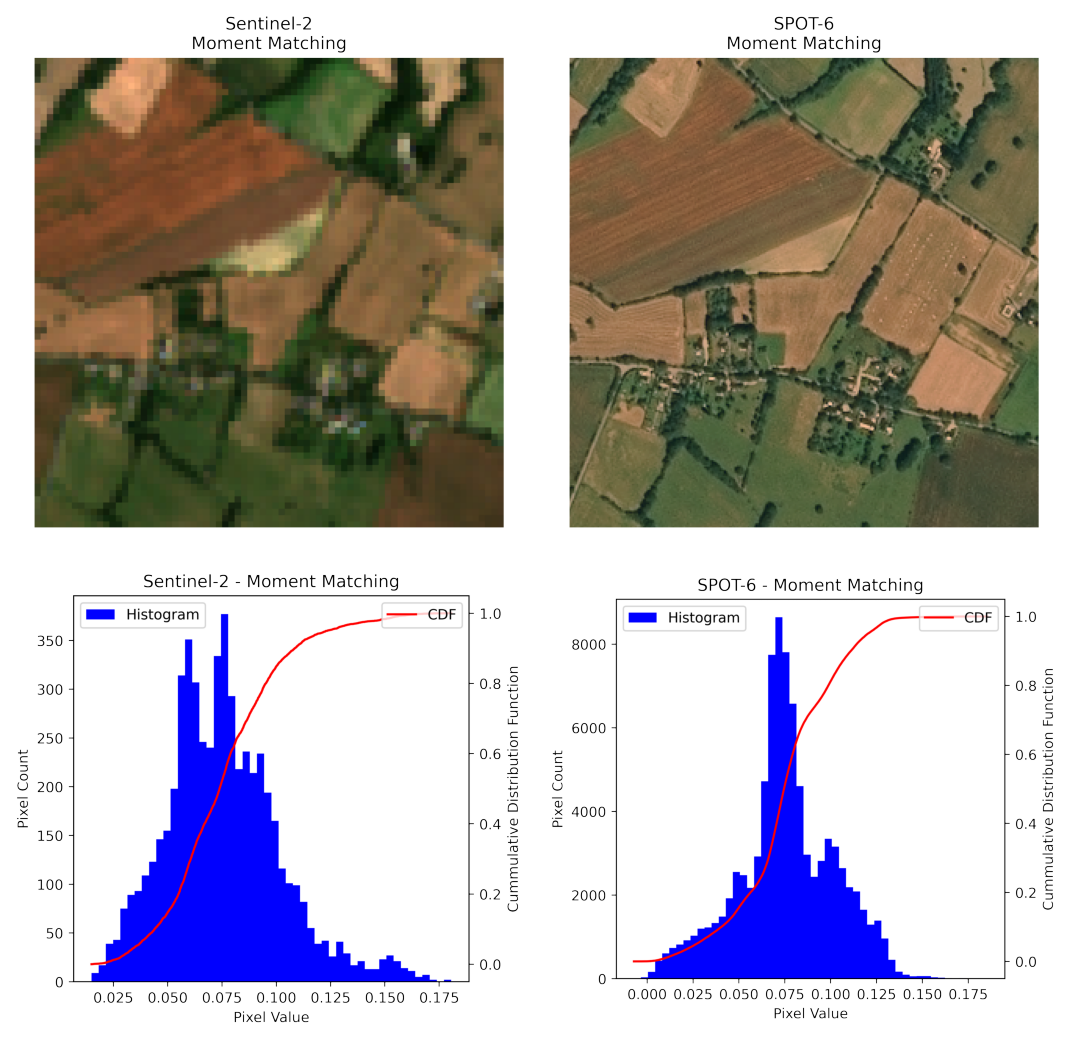

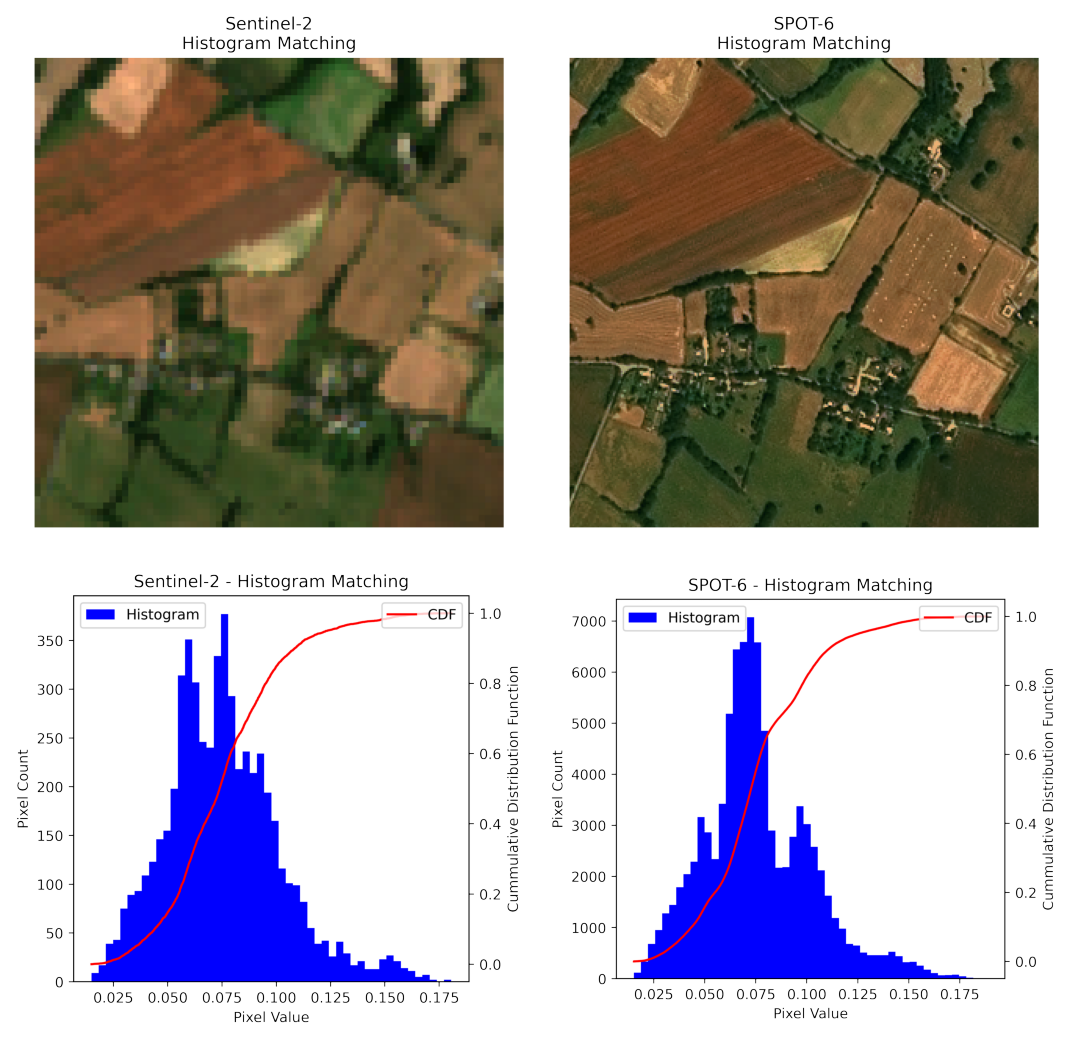

In [10]:
combine("image_Sentinel-2_Standardization.png","image_SPOT-6_Standardization.png","sentinel_graph_Standardization.png","spot_graph_Standardization.png",title="00_standardization.png")
combine("image_Sentinel-2_Moment_Matching.png","image_SPOT-6_Moment_Matching.png","sentinel_graph_Moment_Matching.png","spot_graph_Moment_Matching.png",title="00_moment_matching.png")
combine("image_Sentinel-2_Histogram_Matching.png","image_SPOT-6_Histogram_Matching.png","sentinel_graph_Histogram_Matching.png","spot_graph_Histogram_Matching.png","00_histogram_matching.png")

# Canny Edge

In [48]:
from skimage import feature
import cv2

In [51]:
    def interpolate(img,size=300):
        
        """
        Input:
            - Image
        Output:
            - Image upsampled 
        """
        dim = (size, size)
        b1 = cv2.resize(img[0], dim, interpolation = cv2.INTER_CUBIC)
        b2 = cv2.resize(img[1], dim, interpolation = cv2.INTER_CUBIC)
        b3 = cv2.resize(img[2], dim, interpolation = cv2.INTER_CUBIC)
        
        img = np.dstack((b1,b2,b3))
        img = np.transpose(img,(2,0,1))
        return(img)
    
    def minmax_percentile(img,perc=2):
      lower = np.percentile(img,perc)
      upper = np.percentile(img,100-perc)
      img[img>upper] = upper
      img[img<lower] = lower
      return(img-np.min(img) ) / (np.max(img)-np.min(img))

    def rgb2gray(rgb):

        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

        return gray

In [131]:
loader_moment = load_dataloader(dl_type="moment_matching")

In [132]:
lr,hr = next(iter(loader_moment)) # get images
lr,hr = lr.numpy()[0],hr.numpy()[0] # transform to np
lr,hr = minmax_percentile(lr),minmax_percentile(hr) # perform minmax strecth
#lr = interpolate(lr,300) # interpolate sentinel up
lr,hr = lr.transpose(1,2,0),hr.transpose(1,2,0) # transpose to plt shape
lr_g,hr_g = rgb2gray(lr),rgb2gray(hr)

In [133]:
edges_lr_1 = feature.canny(lr_g)
edges_lr_3 = feature.canny(lr_g, sigma=3)

edges_hr_1 = feature.canny(hr_g)
edges_hr_3 = feature.canny(hr_g, sigma=3)

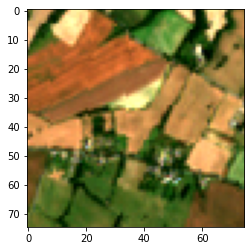

In [134]:
plt.imshow(lr)

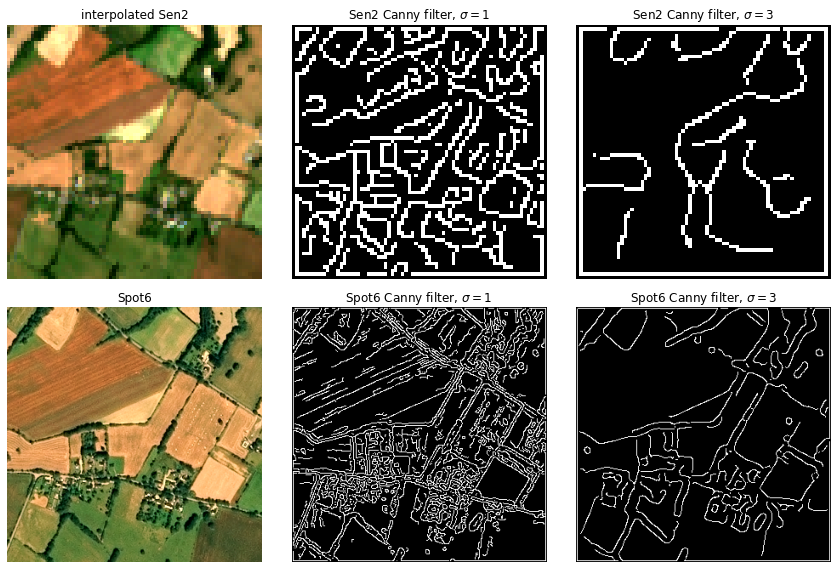

In [135]:
# display results
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
ax = ax.flatten()
ax[0].imshow(lr)
ax[0].set_title('interpolated Sen2', fontsize=12)

ax[1].imshow(edges_lr_1, cmap='gray')
ax[1].set_title(r'Sen2 Canny filter, $\sigma=1$', fontsize=12)

ax[2].imshow(edges_lr_3, cmap='gray')
ax[2].set_title(r'Sen2 Canny filter, $\sigma=3$', fontsize=12)

ax[3].imshow(hr)
ax[3].set_title('Spot6', fontsize=12)

ax[4].imshow(edges_hr_1, cmap='gray')
ax[4].set_title(r'Spot6 Canny filter, $\sigma=1$', fontsize=12)

ax[5].imshow(edges_hr_3, cmap='gray')
ax[5].set_title(r'Spot6 Canny filter, $\sigma=3$', fontsize=12)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.savefig("canny_edges.png",dpi=300)
plt.show()

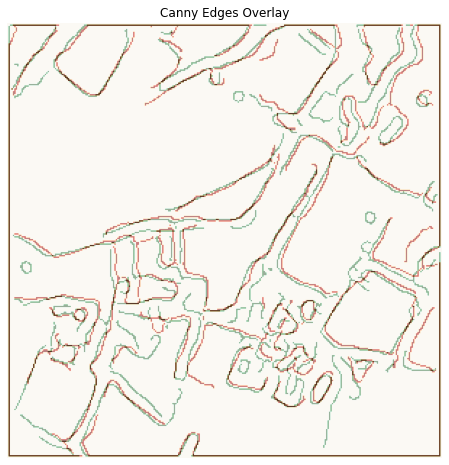

In [130]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
#ax = ax.flatten()
ax.imshow(edges_lr_3.astype(int),cmap="OrRd",alpha=.8)
ax.imshow(edges_hr_3.astype(int),cmap="BuGn",alpha=.4)
ax.axis('off')
ax.set_title("Canny Edges Overlay")
plt.savefig("canny_edges_overlay.png",dpi=300)
plt.show()